# (24) mnist fit — mlp, iter

**Motivation**: host = ```mach```, device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 2
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:2  ———  host: mach

In [3]:
def _eval():
    seq_total = 1 if tr.model.cfg.seq_len == 1 else 1000
    results = tr.analysis('vld', seq_total=seq_total, n_data_batches=5, verbose=False)
    
    fig, axes = plot_convergence(results, color='C0', display=False)
    fig.suptitle(name, fontsize=16, fontfamily='monospace', color='darkgreen', y=1.1)
    display(fig)

In [4]:
dataset = 'MNIST'
model_type = 'poisson'
archi_type = 'jacob|mlp'

In [5]:
seq_lengths = [4, 16, 64]
beta_factors = [3/8, 1/2]
looper = itertools.product(
    seq_lengths[::-1],
    beta_factors,
)

name: <jacob|mlp>_(64,24.0)

poisson_MNIST_t-64_z-[128]_<jacob|mlp>
b200-ep400-lr(0.002)_beta(24:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_24,13:41)

epoch # 400, avg loss: 8.868106: 100%|████| 400/400 [11:18:17<00:00, 101.74s/it]


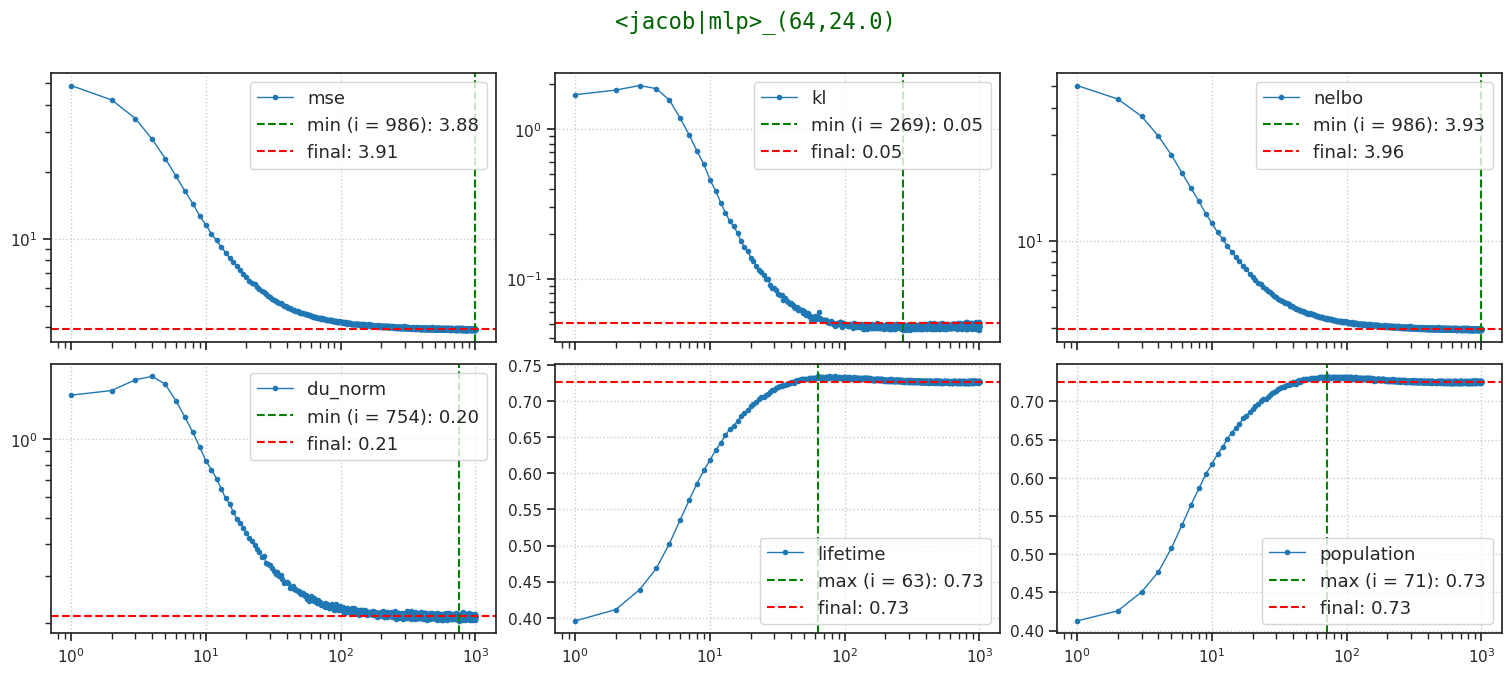

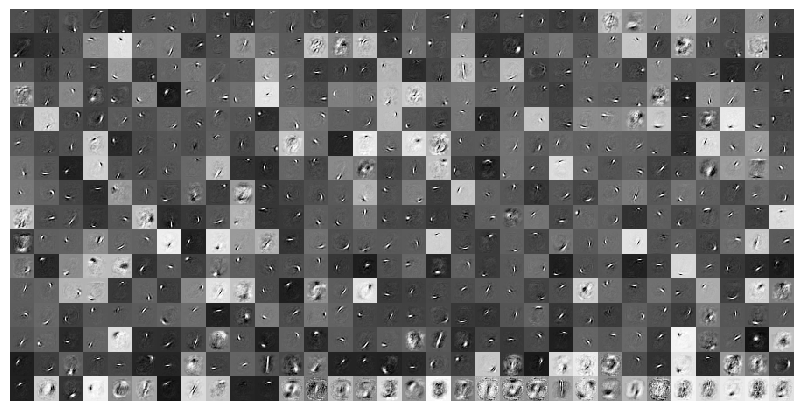

name: <jacob|mlp>_(64,32.0)

poisson_MNIST_t-64_z-[128]_<jacob|mlp>
b200-ep400-lr(0.002)_beta(32:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_25,00:59)

epoch # 53, avg loss: 8.047166:  13%|▌   | 53/400 [1:33:02<10:10:31, 105.57s/it]

In [ ]:
%%time


for seq_len, factor in looper:
    cfg_vae, cfg_tr = default_configs(
        dataset=dataset,
        model_type=model_type,
        archi_type=archi_type,
    )
    cfg_vae['seq_len'] = seq_len
    cfg_tr['kl_beta'] = factor * seq_len

    vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
    tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

    name = f"<{archi_type}>_({tr.model.cfg.seq_len},{tr.cfg.kl_beta:0.1f})"
    print(f"name: {name}\n\n{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n\n")

    tr.train()
    _eval()

    w = tr.model.layer.get_weight()
    norms = tonp(torch.linalg.vector_norm(w, dim=1))
    _ = tr.model.show(order=np.argsort(norms), dpi=100, pad=0)

In [ ]:
print(tr.model.layer.dec)